# **Experiment Tracking with Weights and Biases (W&B)**

In [1]:
from diffusers import UNet2DModel

import pickle,gzip,math,os,time,shutil,torch,random,logging
import fastcore.all as fc
import matplotlib as mpl, matplotlib.pyplot as plt
import numpy as np
from collections.abc import Mapping
from pathlib import Path
from functools import partial

from fastcore.foundation import L
import torchvision.transforms.functional as TF,torch.nn.functional as F
from torch import tensor,nn,optim
from torch.utils.data import DataLoader,default_collate
from torch.nn import init
from torch.optim import lr_scheduler
from torcheval.metrics import MulticlassAccuracy
from datasets import load_dataset, load_dataset_builder

from miniai.datasets import *
from miniai.conv import *
from miniai.learner import *
from miniai.activations import *
from miniai.init import *
from miniai.sgd import *
from miniai.resnet import *
from miniai.augment import *
from miniai.accel import *

In [2]:
mpl.rcParams['image.cmap'] = 'gray_r'
logging.disable(logging.WARNING)

## **Load Data**

For this notebook, we will be working with:
- [CIFAR10](https://paperswithcode.com/dataset/cifar-10) dataset, which is a step up in complexity when compared to Fashion MNIST and is usually considered as the smallest dataset in alot of generative and CV research.
- [Weights and Biases](https://wandb.ai) for experiment tracking.

We're doing this to make sure that our ideas, which were used to create most of the MiniAi functionality, hold when new datasets, features and tools - such as W&B - are added to the mix.

In [3]:
xl, yl = 'img', 'label'
name = "cifar10"
dsd = load_dataset(name)

@inplace
def transformi(b): b[xl] = [TF.to_tensor(o)-0.5 for o in b[xl]]

bs = 32
tds = dsd.with_transform(transformi)
dls = DataLoaders.from_dd(tds, bs, num_workers=8)

In [4]:
# Training data loader with xb and yb
dt = dls.train
xb, yb = next(iter(dt))

In [5]:
# We're now working with 3 channel i.e. RGB, images
xb.shape

torch.Size([32, 3, 32, 32])

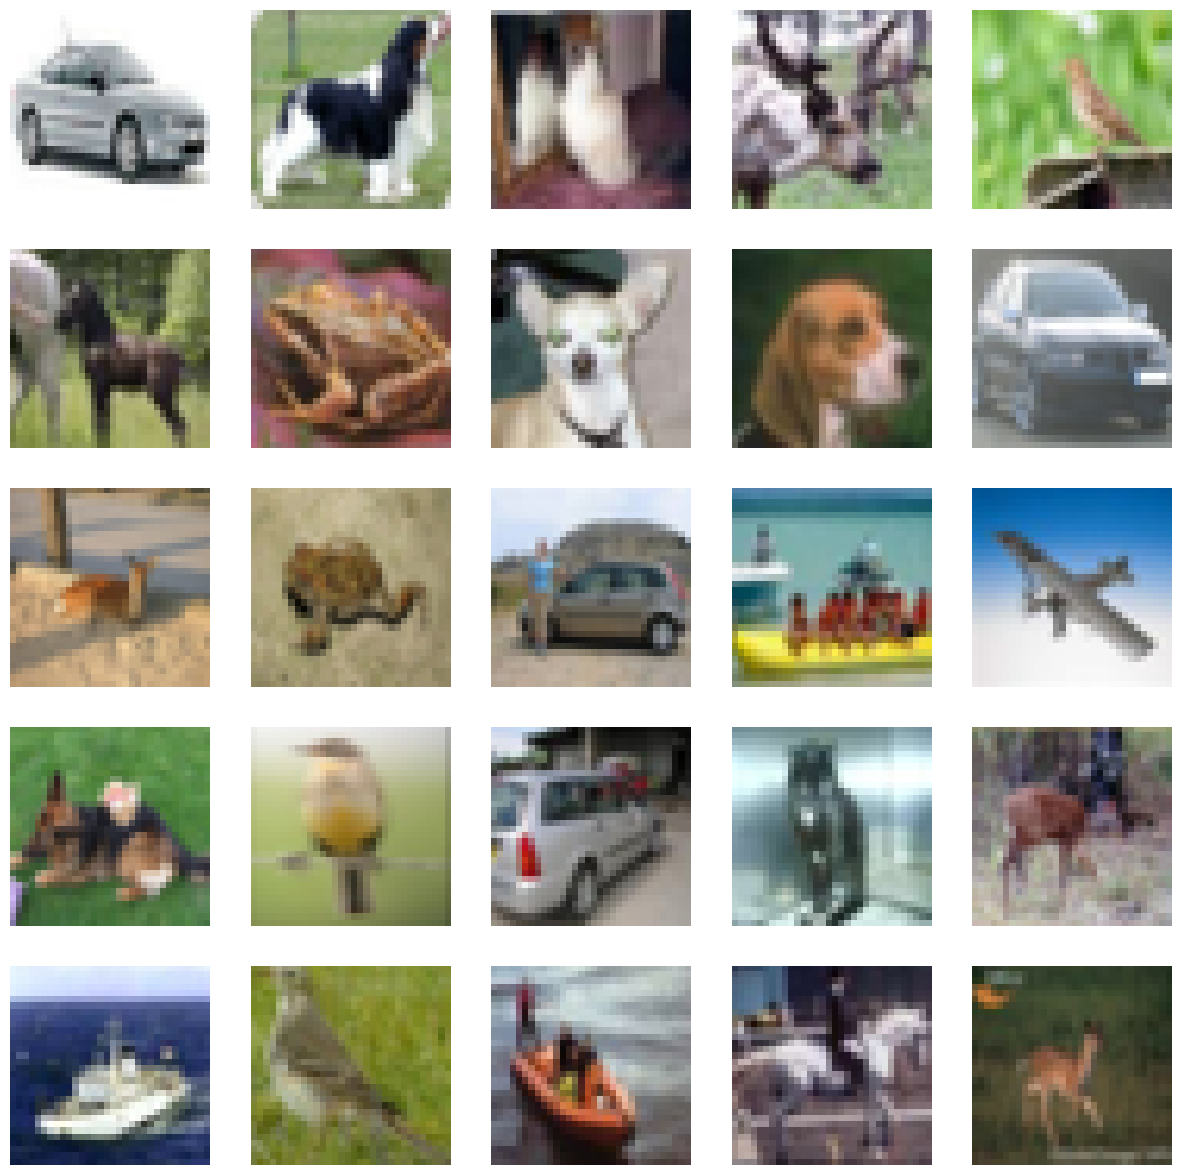

In [6]:
# Show images in batch
# Adding 0.5 fixes brightness problems
show_images(xb[:25]+0.5)

In [7]:
from types import SimpleNamespace

def linear_sched(beta_min=0.0001, beta_max=0.02, n_steps=1000):
    beta = torch.linspace(beta_min, beta_max, n_steps)
    # SimpleNamespace allows us to initialize attributes while constructing the object.
    return SimpleNamespace(a=1.-beta, abar=(1.-beta).cumprod(dim=0), sig=beta.sqrt())

We will use the same `noisify()` function to add noise in channel images.

In [8]:
n_steps = 1000
lin_abar = linear_sched(beta_max=0.01)
alphabar = lin_abar.abar
alpha = lin_abar.a
sigma = lin_abar.sig

In [9]:
def noisify(x0, ᾱ):
    device = x0.device
    n = len(x0)
    t = torch.randint(0, n_steps, (n,), dtype=torch.long)
    ε = torch.randn(x0.shape, device=device)
    ᾱ_t = ᾱ[t].reshape(-1, 1, 1, 1).to(device)
    xt = ᾱ_t.sqrt()*x0 + (1-ᾱ_t).sqrt()*ε
    return (xt, t.to(device)), ε

In [10]:
(xt, t), ε = noisify(xb[:25], alphabar)
t

tensor([869, 563, 352, 242, 473, 175, 221, 478, 563, 805, 184, 213, 716, 725,
        644, 171, 600, 679, 293, 652, 574, 177, 688,  19, 792])

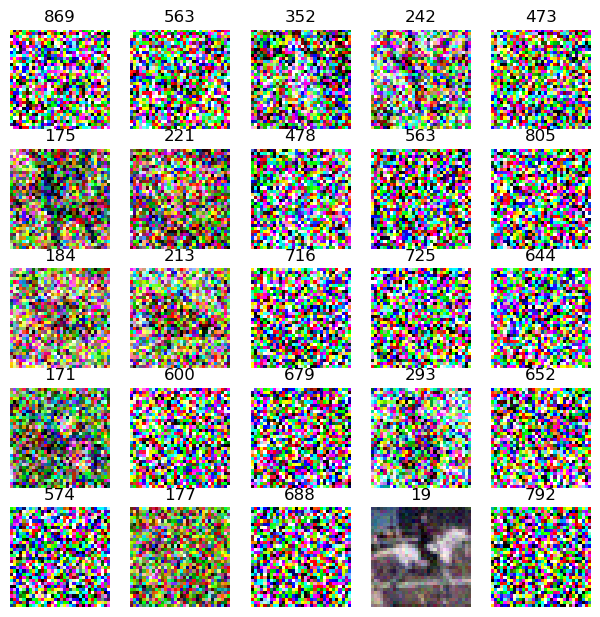

In [11]:
# Visualizing noisified images
titles = fc.map_ex(t[:25], '{}')
show_images(xt[:25].clip(-0.5, 0.5) + 0.5, imsize=1.5, titles=titles)

## **Training**

In [12]:
# Setting up the ResNet blocks from before
class UNet(UNet2DModel):
    def forward(self, x): return super().forward(*x).sample

def init_ddpm(model):
    for o in model.down_blocks:
        for p in o.resnets:
            p.conv2.weight.data.zero_()
            for p in fc.L(o.downsamplers): init.orthogonal_(p.conv.weight)

    for o in model.up_blocks:
        for p in o.resnets: p.conv2.weight.data.zero_()

    model.conv_out.weight.data.zero_()

def collate_ddpm(b): return noisify(default_collate(b)[xl], alphabar)

def dl_ddpm(ds, nw=4): return DataLoader(ds, batch_size=bs, collate_fn=collate_ddpm, num_workers=nw)

In [13]:
dls = DataLoaders(dl_ddpm(tds['train']), dl_ddpm(tds['test']))

In [14]:
# Using the model we created for FashionMNIST
model = UNet(in_channels=3, out_channels=3, block_out_channels=(32, 64, 128, 256), norm_num_groups=8)
sum(p.numel() for p in model.parameters())

15891907

In [15]:
# Moving away from our previous model defaults to the ones used in Diffusers
model = UNet(in_channels=3, out_channels=3)
sum(p.numel() for p in model.parameters())

274056163

In [16]:
# Clean up memory
clean_mem()

In [17]:
# Setting up the model for training, we will train for only one epoch
# and then use the sampling technique below to get judge the model's initial
# performance.
lr = 1e-3
epochs = 1
opt_func = partial(optim.AdamW, eps=1e-5)
tmax = epochs * len(dls.train)
sched = partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax)
cbs = [DeviceCB(), MixedPrecision(), ProgressCB(plot=True), MetricsCB(), BatchSchedCB(sched)]
model = UNet(in_channels=3, out_channels=3)

init_ddpm(model)
learn = Learner(model, dls, nn.MSELoss(), lr=lr, cbs=cbs, opt_func=opt_func)

loss,epoch,train
0.055,0,train
0.027,0,eval


/home/bchaudhry/miniforge3/envs/miniai/lib/python3.11/site-packages/torch/nn/modules/conv.py:459: UserWarning: Applied workaround for CuDNN issue, install nvrtc.so (Triggered internally at /opt/conda/conda-bld/pytorch_1682343995622/work/aten/src/ATen/native/cudnn/Conv_v8.cpp:80.)
  return F.conv2d(input, weight, bias, self.stride,


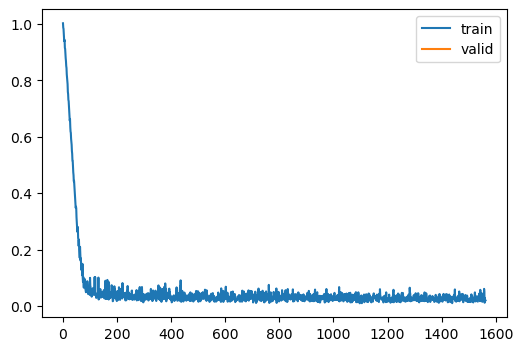

In [18]:
learn.fit(epochs)

In [19]:
# We will also carry over the sampling function before before
def sample(model, sz):
    ps = next(model.parameters())
    x_t = torch.randn(sz).to(ps)
    preds = []
    for t in reversed(range(n_steps)):
        t_batch = torch.full((x_t.shape[0],), t, device=ps.device, dtype=torch.long)
        z = (torch.randn(x_t.shape) if t > 0 else torch.zeros(x_t.shape)).to(ps)
        ᾱ_t1 = alphabar[t-1] if t > 0 else torch.tensor(1)
        b̄_t = 1 - alphabar[t]
        b̄_t1 = 1 - ᾱ_t1
        noise = model((x_t, t_batch))
        x_0_hat = ((x_t - b̄_t.sqrt() * noise)/alphabar[t].sqrt())
        x_t = x_0_hat * ᾱ_t1.sqrt()*(1-alpha[t])/b̄_t + x_t * alpha[t].sqrt()*b̄_t1/b̄_t + sigma[t]*z
        preds.append(x_t.float().cpu())
    return preds

In [ ]:
%%time
samples = sample(model, (bs, 3, 32, 32))

In [ ]:
s = (samples[-1] + 0.5).clamp(0, 1)
show_images(s[:16], imsize=1.5)

While this approach can work, in reality, we will need to iterate quickly while carrying out both tracking and logging. Automating is usually the best way to go and one of those ways is to use Weights and Biases to handle all the tracking for us.

## **Weights and Biases CB**

In [20]:
clean_mem()

In [21]:
import wandb

class WandBCB(MetricsCB): # Inherting from MetricsCB
    order = 100
    def __init__(self, config, *ms, project='ddpm_cifar10', **metrics):
        fc.store_attr()
        super().__init__(*ms, **metrics)

    def before_fit(self, learn): wandb.init(project=self.project, config=self.config)
    def after_fit(self, learn): wandb.finish()

    def _log(self, d): # Replacing the ProgessCB to allow W&B to handle logging
        if self.train:
            wandb.log({'train_'+m: float(d[m]) for m in self.all_metrics})
        else:
            wandb.log({'val_'+m: float(d[m]) for m in self.all_metrics})
            wandb.log({'samples': self.sample_figure(learn)})
        print(d)

    def sample_figure(self, learn):
        with torch.no_grad():
            samples = sample(learn.model, (16, 3, 32, 32))
        s = (samples[-1] + 0.5).clamp(0, 1)
        plt.clf()
        fig.axs = get_grid(16)
        for im, ax in zip(s[:16], axs.flat): show_image(im, ax=ax)
        return fig

    def after_batch(self, learn):
        super().after_batch(learn)
        wandb.log({'loss': learn.loss})

In [24]:
lr = 1e-3
epochs = 2
opt_func = partial(optim.AdamW, eps=1e-5)
tmax = epochs * len(dls.train)
sched = partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax)
wandbcb =  WandBCB(config={'lr':lr, 'epochs':epochs, 'comments':'default unet logging test'})
cbs = [DeviceCB(), MixedPrecision(), ProgressCB(plot=True), wandbcb, BatchSchedCB(sched)]
model = model = UNet(in_channels=3, out_channels=3)
init_ddpm(model)
learn = Learner(model, dls, nn.MSELoss(), lr=lr, cbs=cbs, opt_func=opt_func)

In [ ]:
learn.fit(epochs)

loss,█▆▅▄▁▁
loss,0.94842
